In [2]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='a556e174-f2f5-4aef-945b-41d57f7fa771', project_access_token='p-c9e64846972362bdb29fbe588a7b19ee4e97a999')
pc = project.project_context


In [3]:
!pip -q install folium
!pip install geocoder
!pip install uszipcode
!pip install ipython-sql # SQL magic function
!pip install pydotplus
!pip install python-graphviz

     |████████████████████████████████| 102kB 1.1MB/s ta 0:00:01
     |████████████████████████████████| 143kB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 204kB 55.3MB/s eta 0:00:01
     |████████████████████████████████| 122kB 56.0MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/7e/f5/4b/c19e6276126325eb8071b273347c05a830c37a82b9b3b81510
Successfully built autopep8
  Stored in directory: /home/dsxuser/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
Successfully built prettytable
     |████████████████████████████████| 286kB 1.1MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


  ERROR: Could not find a version that satisfies the requirement python-graphviz (from versions: none)
ERROR: No matching distribution found for python-graphviz


In [4]:
from __future__ import print_function
from bs4 import BeautifulSoup
import requests 
from geopy.geocoders import Nominatim 
import requests 
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
import folium
import geocoder
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from uszipcode import SearchEngine
import re
import json
import ibm_db
%matplotlib inline 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Foursquare Information
CLIENT_ID = 'S35AD1C005HPBW0YRHEYKQ5PPU1Y3JTJVYAUDAWG35SEJV30' # your Foursquare ID
CLIENT_SECRET = 'DXJSLAZ451MNKIIHPYSVMULFYUUCC05K1GZU14HDT3WJSWWM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
BING_KEY ='AjrFKOWxRFQeqK059icDBF98qBrdOCOB13g5jZ_ffOLjEGNTpcRasBnXneVcCH_w'

# Where should I live in Los Angeles

## Introduction

It is a truth universally acknowledged that most conversations in 21st century America are about where best to live in one's current city. This project seeks to simplify the process by analyzing a range of data for a specific city to identify neighborhood characteristics to create neighborhoods of similar clusters as well as decision tree to help someone moving to a new house or apartment in the Los Angeles area. If this is successful, the system will be expanded into other cit

## Data

The system will be using:
1. Foursquare for local venue. We may add yelp's api to expand the data set, based on price and availability.
2. Restaurant health reports from lacity.org.
3. Average home value by zip code from http://www.laalmanac.com/economy/ec37b.php
4. Libraries and cultural locations in each zip code from data.lacity.org



In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=750, limit=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
def reverse_geocode(df):
    search = SearchEngine(simple_zipcode=True)
    data = []
    #for i in range(0,len(businesses_df)):
    for i in range(0,10):
        if businesses_df['LOCATION'][i] != 0:
            lat,long = tuple(df['LOCATION'][i].split(","))
            lat = float(re.sub("\(", "", lat))
            long = float(re.sub("\)", "", long))
            result = search.by_coordinates(lat,long, radius=30, returns=1)
            if len(result):
                data.append([df.index[i],result[0].zipcode,df['LOCATION'][i]])
        else:
            data.append([df.index[i],0,df['LOCATION'][i]])
    return data

In [6]:
URL = "http://www.laalmanac.com/economy/ec37b.php"
r = requests.get(URL) 
soup = BeautifulSoup(r.content, 'html.parser') 

table = soup.find('table')
table_header = table.find_all('th')
table_data = table.find_all('tr')
data = []
for tr in table_data:
    td = tr.find_all('td')
    if len(td):
        row = [tr.text for tr in td]
        data.append(row)

In [7]:

df_lacounty_real_estate = pd.DataFrame(data, columns=["Zip Code", "Community","2018 Cost","2017 Cost","2016 Cost","2015 Cost","2014 Cost","2013 Cost"])
columns=["2018 Cost","2017 Cost","2016 Cost","2015 Cost","2014 Cost","2013 Cost"]
df_lacounty_real_estate[columns] = df_lacounty_real_estate[columns]
df_lacounty_real_estate[columns] = df_lacounty_real_estate[columns].replace({'[$,]': ''}, regex=True)
lacounty_real_estate_clean = df_lacounty_real_estate
for col in columns:
    indexNames = df_lacounty_real_estate[df_lacounty_real_estate[col] == 'N/A' ].index
    lacounty_real_estate_clean.drop(indexNames , inplace=True)
    lacounty_real_estate_clean[col] = lacounty_real_estate_clean[col].astype(float, inplace=True)
lacounty_real_estate_clean.head()
for col in range(0,len(columns) - 1):
    lacounty_real_estate_clean[columns[col]+' Growth']=(lacounty_real_estate_clean[columns[col]]-lacounty_real_estate_clean[columns[col+1]])/lacounty_real_estate_clean[columns[col+1]]
la_data  = lacounty_real_estate_clean[['Zip Code','Community','2018 Cost','2018 Cost Growth','2017 Cost Growth','2016 Cost Growth']]


In [8]:
zip_codes = la_data['Zip Code']
data = []
for zip_code in zip_codes:
    g = geocoder.arcgis('{}, Los Angeles, California'.format(zip_code))
    data.append([zip_code,g.lat,g.lng])
la_geo = pd.DataFrame(data, columns=["Zip Code", "Lat","Long"])
la_geo
la_data = la_data.merge(la_geo, on='Zip Code')

In [9]:
la_data

Zip Code                                          Community  2018 Cost  \
0      90001   Los Angeles (South Los Angeles), Florence-Graham   369300.0   
1      90002         Los Angeles (Southeast Los Angeles, Watts)   372600.0   
2      90003  Los Angeles (South Los Angeles, Southeast Los ...   379800.0   
3      90004  Los Angeles (Hancock Park, Rampart Village, Vi...  1590400.0   
4      90005  Los Angeles (Hancock Park, Koreatown, Wilshire...  1721400.0   
5      90006  Los Angeles (Byzantine-Latino Quarter, Harvard...   853100.0   
6      90007  Los Angeles (Southeast Los Angeles, Univerity ...   685000.0   
7      90008  Los Angeles (Baldwin Hills, Crenshaw, Leimert ...   851700.0   
8      90011                Los Angeles (Southeast Los Angeles)   404200.0   
9      90012  Los Angeles (Downtown Civic Center, Chinatown,...   622500.0   
10     90013  Los Angeles (Downtown Central, Downtown Fashio...   606800.0   
11     90014  Los Angeles (Downtown Historic Core, Arts Dist...   723500.0   
12     90015  Los Angeles (Dowtown Fashion District, South P...   609600.0   
13     90016                 Los Angeles (Mid-City, West Adams)   750900.0   
14     90017  Los Angeles (Downtown Bunker Hill, City West, ...   674600.0   
15     90018         Los Angeles (Jefferson Park, Leimert Park)   704100.0   
16     90019  Los Angeles (Arlington Heights, Country Club P...  1157700.0   
17     90020  Los Angeles (Hancock Park, Western Wilton, Wil...  3954900.0   
18     90022                                   East Los Angeles   451800.0   
19     90023  Los Angeles (Boyle Heights), Commerce,  East L...   418600.0   
20     90024                             Los Angeles (Westwood)  2822600.0   
21     90025           Los Angeles (Sawtelle, West Los Angeles)  1787000.0   
22     90026               Los Angeles (Echo Park, Silver Lake)   984800.0   
23     90027  Los Angeles (Griffith Park, Hollywood, Los Feliz)  1718300.0   
24     90028                            Los Angeles (Hollywood)  1200300.0   
25     90029                       Los Angeles (East Hollywood)   930300.0   
26     90031   Los Angeles (Lincoln Heights, Montecito Heights)   648900.0   
27     90032            Los Angeles (El Sereno, Monterey Hills)   621600.0   
28     90033                        Los Angeles (Boyle Heights)   484000.0   
29     90034                                Los Angeles (Palms)  1419300.0   
30     90035                         Los Angeles (West Fairfax)  1826900.0   
31     90036  Los Angeles (Fairfax, Melrose, Miracle Mile, P...  1880400.0   
32     90037                    Los Angeles (South Los Angeles)   458400.0   
33     90038                            Los Angeles (Hollywood)  1272700.0   
34     90039  Los Angeles (Atwater Village, Elysian Valley, ...  1061000.0   
35     90040                                           Commerce   454500.0   
36     90041                           Los Angeles (Eagle Rock)   916300.0   
37     90042                        Los Angeles (Highland Park)   814400.0   
38     90043  Los Angeles (Hyde Park, View Park, Windsor Hills)   663300.0   
39     90044            Athens, Los Angeles (South Los Angeles)   431700.0   
40     90045  Los Angeles (Los Angeles International Airport...  1228400.0   
41     90046          Los Angeles (Mt Olympus) / West Hollywood  1902000.0   
42     90047                    Los Angeles (South Los Angeles)   493700.0   
43     90048        Los Angeles (Mid-City West), West Hollywood  2161200.0   
44     90049           Los Angeles (Bel Air Estates, Brentwood)  3326400.0   
45     90056                                     Ladera Heights  1354100.0   
46     90057                             Los Angeles (Westlake)   811600.0   
47     90059  Los Angeles (Southeast Los Angeles, Watts), Wi...   386200.0   
48     90061                    Los Angeles (South Los Angeles)   402900.0   
49     90062                    Los Angeles (South Los Angeles)   572700.0   
50     90063          City

In [10]:
!wget https://data.lacounty.gov/api/geospatial/65v5-jw9f?method=export&format=GeoJSON
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [11]:
la_library_df = pd.read_csv("https://data.lacity.org/api/views/vdjf-if28/rows.csv")
data = []
for i in range(0,len(la_library_df)):
    bob = la_library_df['ADDRESS'][i][la_library_df['ADDRESS'][i].find('CA ')+3:la_library_df['ADDRESS'][i].find('CA ')+8]
    data.append([bob,1])

libraryZips = pd.DataFrame(data,columns=["Zip Code", "Libraries"])

library_count = libraryZips.groupby("Zip Code").count()


In [12]:
la_data = la_data.merge(library_count, on='Zip Code',how='outer')
la_data.fillna({"Libraries":0}, inplace=True)
la_data.tail()

Zip Code                                          Community  2018 Cost  \
259    93536  Del Sur, Fairmont, Lancaster, Metler Valley, N...   356500.0   
260    93543             Juniper Hills, Littlerock, Sun Village   284800.0   
261    93550                         Lake Los Angeles, Palmdale   278000.0   
262    93551                 City Ranch, Leona Valley, Palmdale   394800.0   
263    93552                                           Palmdale   309900.0   

     2018 Cost Growth  2017 Cost Growth  2016 Cost Growth       Lat  \
259          0.058492          0.102455          0.115778  34.66749   
260          0.130159          0.104294          0.214476  34.53390   
261          0.084243          0.132009          0.137619  34.57812   
262          0.060720          0.081348          0.091659  34.60954   
263          0.081675          0.124411          0.093562  34.56584   

          Long  Libraries  
259 -118.18251        0.0  
260 -117.96553        0.0  
261 -118.11419        0.0  
262 -118.18882        0.0  
263 -118.03113        0.0

In [13]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_f20212cd71554cc28d2155723d40bc4d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='fMlFl7jwjP-Rc-NEBjAkcZxfm7Bw-Gr-jOjuiaKTml3E',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_f20212cd71554cc28d2155723d40bc4d.get_object(Bucket='courseracapstone-donotdelete-pr-d1qntuw0zwpvzm',Key='california_total_listings.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

pot = pd.read_csv(body)
pot.head()



id       wmid                                                url  \
0  47603  155018451         https://weedmaps.com/dispensaries/the-crop   
1  55520  137432461  https://weedmaps.com/dispensaries/love-faith-a...   
2  54791  681677711  https://weedmaps.com/dispensaries/grande-vista...   
3  48231  290201419  https://weedmaps.com/dispensaries/natural-reme...   
4  28299  438366567  https://weedmaps.com/dispensaries/thc-the-heal...   

                                  name  \
0                             The Crop   
1                 Love Faith and Unity   
2                  Grande Vista 15 CAP   
3  NRC Holistic Health Services Clinic   
4             THC - The Healing Center   

                                          avatar_url  \
0  https://images.weedmaps.com/dispensaries/000/0...   
1  https://images.weedmaps.com/dispensaries/000/0...   
2  https://images.weedmaps.com/dispensaries/000/0...   
3  https://images.weedmaps.com/dispensaries/000/0...   
4  https://images.weedmaps.com/dispensaries/000/0...   

                                          intro_body  reviews_count    rating  \
0  <p>We couldn't be more proud of our Crop Famil...           3787  4.982678   
1  <p>Hello all and Welcome to The Church of Love...          11598  4.916951   
2  <p>***</p> <p>Welcome to Grande Vista 15 CAP; ...           2061  4.902863   
3                                                NaN           3483  4.921677   
4  <p><strong>WE ARE RECREATIONAL USE ANY VALID I...           2320  4.919914   

   feature_order package_level  package_level_raw license_type  \
0              1  listing_plus                  2      medical   
1              1  listing_plus                  2      medical   
2              1  listing_plus                  2      medical   
3              1  listing_plus                  2       hybrid   
4              1  listing_plus                  2       hybrid   

                        address         city                         region  \
0                 5950 State Rd  Bakersfield                    Bakersfield   
1               11923 Cedar Ave  Bloomington  Bloomington / Rialto / Colton   
2   1462 South Grande Vista Ave  Los Angeles                        East LA   
3  5272 Jerusalem Court Suite D      Modesto                        Modesto   
4    1400 Needles Hwy. Unit 100      Needles               Needles / Blythe   

        state zip_code    phone_number   latitude   longitude  \
0  California    93308    661-393-7342  35.414963 -119.056766   
1          CA    92316    909-347-5771  34.037823 -117.395833   
2  California    90023    323-335-8059  34.018280 -118.209980   
3          CA    95356   (209)322-5129  37.716751 -120.999821   
4          CA    92363  (760) 447-2663  34.848528 -114.610832   

                                        todays_hours  is_delivery  \
0  {'opening_time': None, 'closing_time': None, '...        False   
1  {'opening_time': ' 8:00am', 'closing_time': '1...        False   
2  {'opening_time': '10:00am', 'closing_time': '1...        False   
3  {'opening_time': '10:00am', 'closing_time': ' ...        False   
4  {'opening_time': ' 6:00am', 'closing_time': '1...        False   

   has_testing  is_recreational  \
0        False            False   
1        False            False   
2        False            False   
3        False            False   
4        False            False   

                                  hours_of_operation  published  \
0  {'sunday': 'Closed', 'monday': 'Closed', 'tues...       True   
1  {'sunday': ' 8:00am - 12:00am', 'monday': ' 8:...       True   
2  {'sunday': '10:00am - 11:45pm', 'monday': '10:...       True   
3  {'sunday': '10:00am -  5:00pm', 'monday': 'Clo...       True   
4  {'sunday': ' 6:00am - 10:00pm', 'monday': ' 6:...       True   

                                           admin_url  \
0  https://weedmaps.com/new_admin/dispensaries/th...   
1  https://weedmaps.com/new_admin/dispensaries/lo...   
2  https://weedmaps.com/

In [14]:
pot_zips = pot[["zip_code","id"]]
pot_count = pot_zips.groupby(["zip_code"]).count()
pot_count.reset_index(inplace=True)
pot_count.rename(columns = {"zip_code":"Zip Code","id":"Marijuana Dispenseries"},inplace=True)
pot_count.head()

Zip Code  Marijuana Dispenseries
0    12345                       2
1     1604                       1
2    31202                       1
3    80201                       1
4    89555                       1

In [15]:
la_data = la_data.merge(pot_count, on='Zip Code',how='outer')
la_data.fillna({"Marijuana Dispenseries":0}, inplace=True)
la_data.dropna(inplace=True)
la_data.tail()


Zip Code                                          Community  2018 Cost  \
259    93536  Del Sur, Fairmont, Lancaster, Metler Valley, N...   356500.0   
260    93543             Juniper Hills, Littlerock, Sun Village   284800.0   
261    93550                         Lake Los Angeles, Palmdale   278000.0   
262    93551                 City Ranch, Leona Valley, Palmdale   394800.0   
263    93552                                           Palmdale   309900.0   

     2018 Cost Growth  2017 Cost Growth  2016 Cost Growth       Lat  \
259          0.058492          0.102455          0.115778  34.66749   
260          0.130159          0.104294          0.214476  34.53390   
261          0.084243          0.132009          0.137619  34.57812   
262          0.060720          0.081348          0.091659  34.60954   
263          0.081675          0.124411          0.093562  34.56584   

          Long  Libraries  Marijuana Dispenseries  
259 -118.18251        0.0                     4.0  
260 -117.96553        0.0                     3.0  
261 -118.11419        0.0                     9.0  
262 -118.18882        0.0                     0.0  
263 -118.03113        0.0                     1.0

Get data

In [16]:
r = requests.get('https://data.lacounty.gov/resource/e7q7-tit4.json')
x = r.json()
df = pd.DataFrame(x)
data = []
for i in range(0,len(df)):
#for i in range(0,10):
    if 'location_1' in x[i]:
        if 'type_of_asset' in x[i]:
            type_of_asset = x[i]['type_of_asset']
        else:
            type_of_asset = "N/A"
        if 'category' in x[i]:
            category = x[i]['category']
        else:
            category = "N/A"
        data.append([x[i]['facility'],type_of_asset,category,json.loads(x[i]['location_1']['human_address'])['zip']])
civic_art = pd.DataFrame(data,columns=['facility','type','category','Zip Code'])
civic_art_categories = civic_art.groupby(['category']).count()
civic_art_categories.reset_index(inplace=True)


In [19]:
#filter the public facilities
bob = civic_art[['type','Zip Code']].loc[civic_art['category'].isin(['Artifacts & Archaeology','Golf','Historic Landscape','Civic Art'])]

bob.reset_index(inplace=True)
bob.drop(["index"],axis=1,inplace=True)
la_onehot = pd.get_dummies(bob[['type']], prefix="", prefix_sep="")
la_onehot['Zip Code'] = bob['Zip Code'] 
la_grouped = la_onehot.groupby('Zip Code').sum().reset_index()
la_grouped['Zip Code'] = la_grouped['Zip Code'].astype(object)
la_grouped.rename(columns={'taxidermy, artifacts' : 'taxidermy - artifacts'},inplace=True )
la_grouped


Zip Code  Civic Art  Historic  Mural - mosaic  N/A  artifacts  \
0     90002          0         0               0    0          0   
1     90022          1         0               0    0          0   
2     90023          0         0               0    0          0   
3     90044          0         0               0    0          0   
4     90047          0         0               0    1          0   
5     90056          0         0               0    0          0   
6     90059          0         0               1    0          0   
7     90063          0         0               0    0          0   
8     90068          0         0               0    0          0   
9     90095          0         0               0    0          0   
10    90242          0         0               0    1          0   
11    90248          0         0               0    1          0   
12    90251          1         0               0    0          0   
13    90260          0         0               0    1          0   
14    90274          0         0               0    1          0   
15    90275          0         0               0    0          0   
16    90304          0         0               0    0          0   
17    90638          0         0               0    1          0   
18    90650          0         0               0    1          0   
19    90704          0         0               0    1          0   
20    90712          0         0               0    0          0   
21    90732          0         0               0    0          0   
22    91001          0         1               0    0          0   
23    91006          0         0               0    0          0   
24    91007          0         0               0    0          1   
25    91011          0         0               0    0          0   
26    91107          0         0               0    0         26   
27    91321          0         0               0    1          1   
28    91342          0         0               0    2          0   
29    91344          0         0               0    0          0   
30    91350          0         0               0    1         42   
31    91384          0         0               0    0          0   
32    91702          0         0               0    0          0   
33    91706          1         0               0    1          0   
34    91733          0         0               0    0          0   
35    91744          0         0               0    0          0   
36    91745          0         0               0    0          0   
37    91746          0         0               0    0          0   
38    91748          0         0               0    0          0   
39    91750          0         0               0    1          0   
40    91773          0         0               0    0          1   
41    93534          0         0               0    0          0   
42    93536          0         0               0    0          0   
43    93553          0         0               0    0         62   
44    93591          1         0               0    0          0   

    character defining feature - urban open space  fossils  historic  \
0                                               0        0         0   
1                                               0        0         0   
2                                               0        0         0   
3                                               0        0         0   
4                                               0        0         0   
5                                               0        0         0   
6                                               0        0         0   
7                                               0        0         0   
8                                               1        0         0   
9                                               0        0         0   
10                                              0        0         0   
11        

In [20]:
la_data = la_data.merge(la_grouped, on='Zip Code',how='outer')
la_data.drop(['N/A'],axis=1,inplace=True)
la_data[['Civic Art', 'Historic', 'Mural - mosaic', 'artifacts','character defining feature - urban open space', 'fossils', 'historic',
       'historic landscape', 'mural', 'mural - painted', 'mural - tile',
       'painting - architectural watercolor', 'prints', 'records', 'sculpture',
       'sculpture - concrete', 'sculpture - fence', 'sculpture - fountain',
       'sculpture - metal', 'sculpture - wood', 'taxidermy - artifacts',
       'tree - historic oak', 'tree grove', 'white oil seep']] = la_data[['Civic Art', 'Historic', 'Mural - mosaic', 'artifacts',
       'character defining feature - urban open space', 'fossils', 'historic',
       'historic landscape', 'mural', 'mural - painted', 'mural - tile',
       'painting - architectural watercolor', 'prints', 'records', 'sculpture',
       'sculpture - concrete', 'sculpture - fence', 'sculpture - fountain',
       'sculpture - metal', 'sculpture - wood', 'taxidermy - artifacts',
       'tree - historic oak', 'tree grove', 'white oil seep']].replace(np.nan, 0)
la_data.dropna(inplace=True)
la_data.tail()

Zip Code                                          Community  2018 Cost  \
259    93536  Del Sur, Fairmont, Lancaster, Metler Valley, N...   356500.0   
260    93543             Juniper Hills, Littlerock, Sun Village   284800.0   
261    93550                         Lake Los Angeles, Palmdale   278000.0   
262    93551                 City Ranch, Leona Valley, Palmdale   394800.0   
263    93552                                           Palmdale   309900.0   

     2018 Cost Growth  2017 Cost Growth  2016 Cost Growth       Lat  \
259          0.058492          0.102455          0.115778  34.66749   
260          0.130159          0.104294          0.214476  34.53390   
261          0.084243          0.132009          0.137619  34.57812   
262          0.060720          0.081348          0.091659  34.60954   
263          0.081675          0.124411          0.093562  34.56584   

          Long  Libraries  Marijuana Dispenseries  Civic Art  Historic  \
259 -118.18251        0.0                     4.0        0.0       0.0   
260 -117.96553        0.0                     3.0        0.0       0.0   
261 -118.11419        0.0                     9.0        0.0       0.0   
262 -118.18882        0.0                     0.0        0.0       0.0   
263 -118.03113        0.0                     1.0        0.0       0.0   

     Mural - mosaic  artifacts  character defining feature - urban open space  \
259             0.0        0.0                                            0.0   
260             0.0        0.0                                            0.0   
261             0.0        0.0                                            0.0   
262             0.0        0.0                                            0.0   
263             0.0        0.0                                            0.0   

     fossils  historic  historic landscape  mural  mural - painted  \
259      0.0       0.0                 0.0    5.0              0.0   
260      0.0       0.0                 0.0    0.0              0.0   
261      0.0       0.0                 0.0    0.0              0.0   
262      0.0       0.0                 0.0    0.0              0.0   
263      0.0       0.0                 0.0    0.0              0.0   

     mural - tile  painting - architectural watercolor  prints  records  \
259           0.0                                  0.0     0.0      0.0   
260           0.0                                  0.0     0.0      0.0   
261           0.0                                  0.0     0.0      0.0   
262           0.0                                  0.0     0.0      0.0   
263           0.0                                  0.0     0.0      0.0   

     sculpture  sculpture - concrete  sculpture - fence  sculpture - fountain  \
259        0.0                   0.0                0.0                   0.0   
260        0.0                   0.0                0.0                   0.0   
261        0.0                   0.0                0.0                   0.0   
262        0.0                   0.0                0.0                   0.0   
263        0.0                   0.0                0.0                   0.0   

     sculpture - metal  sculpture - wood  taxidermy - artifacts  \
259                0.0               0.0                    0.0   
260                0.0               0.0                    0.0   
261                0.0               0.0                    0.0   
262                0.0               0.0                    0.0   
263                0.0               0.0                    0.0   

     tree - historic oak  tree grove  white oil seep  
259                  0.0         0.0             0.0  
260                  0.0         0.0             0.0  
261                  0.0         0.0             0.0  
262                  0.0         0.0             0.0  
263                  0.0         0.0             0.0

In [21]:
r = requests.get('https://data.lacounty.gov/resource/a3k2-6v7z.json')
x = r.json()
df = pd.DataFrame(x)
data = []
for i in range(0,len(df)):
#for i in range(0,10):
    if 'location_1' in x[i]:
        data.append([x[i]['bookstore'],json.loads(x[i]['location_1']['human_address'])['zip']])
bookstores = pd.DataFrame(data,columns=['bookstore','Zip Code'])
bookstore_count = bookstores.groupby(['Zip Code']).count()
bookstore_count.reset_index(inplace=True)

la_data = la_data.merge(bookstore_count, on='Zip Code',how='outer')
la_data.fillna({"bookstore":0}, inplace=True)
la_data.dropna(inplace=True)
la_data.tail()

Zip Code                                          Community  2018 Cost  \
259    93536  Del Sur, Fairmont, Lancaster, Metler Valley, N...   356500.0   
260    93543             Juniper Hills, Littlerock, Sun Village   284800.0   
261    93550                         Lake Los Angeles, Palmdale   278000.0   
262    93551                 City Ranch, Leona Valley, Palmdale   394800.0   
263    93552                                           Palmdale   309900.0   

     2018 Cost Growth  2017 Cost Growth  2016 Cost Growth       Lat  \
259          0.058492          0.102455          0.115778  34.66749   
260          0.130159          0.104294          0.214476  34.53390   
261          0.084243          0.132009          0.137619  34.57812   
262          0.060720          0.081348          0.091659  34.60954   
263          0.081675          0.124411          0.093562  34.56584   

          Long  Libraries  Marijuana Dispenseries  Civic Art  Historic  \
259 -118.18251        0.0                     4.0        0.0       0.0   
260 -117.96553        0.0                     3.0        0.0       0.0   
261 -118.11419        0.0                     9.0        0.0       0.0   
262 -118.18882        0.0                     0.0        0.0       0.0   
263 -118.03113        0.0                     1.0        0.0       0.0   

     Mural - mosaic  artifacts  character defining feature - urban open space  \
259             0.0        0.0                                            0.0   
260             0.0        0.0                                            0.0   
261             0.0        0.0                                            0.0   
262             0.0        0.0                                            0.0   
263             0.0        0.0                                            0.0   

     fossils  historic  historic landscape  mural  mural - painted  \
259      0.0       0.0                 0.0    5.0              0.0   
260      0.0       0.0                 0.0    0.0              0.0   
261      0.0       0.0                 0.0    0.0              0.0   
262      0.0       0.0                 0.0    0.0              0.0   
263      0.0       0.0                 0.0    0.0              0.0   

     mural - tile  painting - architectural watercolor  prints  records  \
259           0.0                                  0.0     0.0      0.0   
260           0.0                                  0.0     0.0      0.0   
261           0.0                                  0.0     0.0      0.0   
262           0.0                                  0.0     0.0      0.0   
263           0.0                                  0.0     0.0      0.0   

     sculpture  sculpture - concrete  sculpture - fence  sculpture - fountain  \
259        0.0                   0.0                0.0                   0.0   
260        0.0                   0.0                0.0                   0.0   
261        0.0                   0.0                0.0                   0.0   
262        0.0                   0.0                0.0                   0.0   
263        0.0                   0.0                0.0                   0.0   

     sculpture - metal  sculpture - wood  taxidermy - artifacts  \
259                0.0               0.0                    0.0   
260                0.0               0.0                    0.0   
261                0.0               0.0                    0.0   
262                0.0               0.0                    0.0   
263                0.0               0.0                    0.0   

     tree - historic oak  tree grove  white oil seep  bookstore  
259                  0.0         0.0             0.0        1.0  
260                  0.0         0.0             0.0        0.0  
261                  0.0         0.0             0.0        1.0  
262                  0.0         0.0             0.0        3.0  
263                  0.0         0.0             0.0        0.0

In [22]:
r = requests.get('https://data.lacounty.gov/resource/fmxp-v6mx.json')
x = r.json()
df = pd.DataFrame(x)
data = []
for i in range(0,len(df)):
#for i in range(0,10):
    if 'location' in x[i]:
        data.append([x[i]['museum'],json.loads(x[i]['location']['human_address'])['zip']])
museums = pd.DataFrame(data,columns=['museums','Zip Code'])
museums_count = museums.groupby(['Zip Code']).count()
museums_count.reset_index(inplace=True)
museums_count


Zip Code  museums
0      90007        3
1      90008        2
2      90010        1
3      90011        1
4      90012       10
5      90013        2
6      90014        1
7      90015        4
8      90018        1
9      90019        1
10     90021        1
11     90024        4
12     90025        1
13     90027        4
14     90028        6
15     90031        2
16     90032        1
17     90034        2
18     90035        3
19     90036       10
20     90037        2
21     90038        1
22     90040        1
23     90041        1
24     90046        1
25     90048        3
26     90049        4
27     90055        1
28     90057        2
29     90064        2
30     90065        1
31     90066        1
32     90068        1
33     90069        4
34     90071        1
35     90077        1
36     90089        2
37     90210        1
38     90211        1
39     90212        1
40     90213        1
41     90220        1
42     90230        2
43     90232        2
44     90241        1
45     90242        1
46     90245        2
47     90254        1
48     90263        1
49     90265        1
50     90272        2
51     90275        1
52     90280        1
53     90291        5
54     90305        1
55     90404        4
56     90405        2
57     90408        1
58     90501        1
59     90505        1
60     90606        1
61     90640        1
62     90650        1
63     90660        1
64     90670        1
65     90704        1
66     90717        2
67     90731        4
68     90733        1
69     90744        1
70     90745        1
71     90746        1
72     90747        1
73     90802        2
74     90803        2
75     90804        1
76     90807        1
77     90810        1
78     90813        1
79     90815        2
80     90840        2
81     91011        1
82     91016        1
83     91017        2
84     91024        1
85     91101        5
86     91103        3
87     91104        1
88     91105        2
89     91108        2
90     91201        1
91     91204        1
92     91214        1
93     91222        1
94     91302        1
95     91304        1
96     91311        1
97     91321        1
98     91330        1
99     91340        1
100    91342        1
101    91345        1
102    91355        1
103    91362        2
104    91364        1
105    91367        1
106    91403        1
107    91406        1
108    91423        2
109    91436        1
110    91506        1
111    91507        1
112    91602        1
113    91605        1
114    91702        1
115    91706        1
116    91711        7
117    91733        1
118    91740        1
119    91741        2
120    91748        1
121    91754        1
122    91765        1
123    91766        2
124    91767        1
125    91769        2
126    91776        1
127    91790        1
128    91801        2
129    93534        1
130    93536        2
131    93584        1
132    93586        1

In [23]:
la_data = la_data.merge(museums_count, on='Zip Code',how='outer')
la_data.fillna({"museums":0}, inplace=True)
la_data.dropna(inplace=True)
la_data.tail()

Zip Code                                          Community  2018 Cost  \
259    93536  Del Sur, Fairmont, Lancaster, Metler Valley, N...   356500.0   
260    93543             Juniper Hills, Littlerock, Sun Village   284800.0   
261    93550                         Lake Los Angeles, Palmdale   278000.0   
262    93551                 City Ranch, Leona Valley, Palmdale   394800.0   
263    93552                                           Palmdale   309900.0   

     2018 Cost Growth  2017 Cost Growth  2016 Cost Growth       Lat  \
259          0.058492          0.102455          0.115778  34.66749   
260          0.130159          0.104294          0.214476  34.53390   
261          0.084243          0.132009          0.137619  34.57812   
262          0.060720          0.081348          0.091659  34.60954   
263          0.081675          0.124411          0.093562  34.56584   

          Long  Libraries  Marijuana Dispenseries  Civic Art  Historic  \
259 -118.18251        0.0                     4.0        0.0       0.0   
260 -117.96553        0.0                     3.0        0.0       0.0   
261 -118.11419        0.0                     9.0        0.0       0.0   
262 -118.18882        0.0                     0.0        0.0       0.0   
263 -118.03113        0.0                     1.0        0.0       0.0   

     Mural - mosaic  artifacts  character defining feature - urban open space  \
259             0.0        0.0                                            0.0   
260             0.0        0.0                                            0.0   
261             0.0        0.0                                            0.0   
262             0.0        0.0                                            0.0   
263             0.0        0.0                                            0.0   

     fossils  historic  historic landscape  mural  mural - painted  \
259      0.0       0.0                 0.0    5.0              0.0   
260      0.0       0.0                 0.0    0.0              0.0   
261      0.0       0.0                 0.0    0.0              0.0   
262      0.0       0.0                 0.0    0.0              0.0   
263      0.0       0.0                 0.0    0.0              0.0   

     mural - tile  painting - architectural watercolor  prints  records  \
259           0.0                                  0.0     0.0      0.0   
260           0.0                                  0.0     0.0      0.0   
261           0.0                                  0.0     0.0      0.0   
262           0.0                                  0.0     0.0      0.0   
263           0.0                                  0.0     0.0      0.0   

     sculpture  sculpture - concrete  sculpture - fence  sculpture - fountain  \
259        0.0                   0.0                0.0                   0.0   
260        0.0                   0.0                0.0                   0.0   
261        0.0                   0.0                0.0                   0.0   
262        0.0                   0.0                0.0                   0.0   
263        0.0                   0.0                0.0                   0.0   

     sculpture - metal  sculpture - wood  taxidermy - artifacts  \
259                0.0               0.0                    0.0   
260                0.0               0.0                    0.0   
261                0.0               0.0                    0.0   
262                0.0               0.0                    0.0   
263                0.0               0.0                    0.0   

     tree - historic oak  tree grove  white oil seep  bookstore  museums  
259                  0.0         0.0             0.0        1.0      2.0  
260                  0.0         0.0             0.0        0.0      0.0  
261                  0.0         0.0             0.0        1.0      0.0  
262                  0.0         0.0             0.0        3.0      0.0  
263                  0.0         0.0   

In [24]:
la_venues = getNearbyVenues(names=la_data['Zip Code'],
                                   latitudes=la_data['Lat'],
                                   longitudes=la_data['Long']
                                  )
la_venues.shape

(10442, 7)

In [25]:
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot['Zip Code'] = la_venues['PostalCode'] 
la_onehot.head()
# move neighborhood column to the first column
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]

la_onehot.tail()


Zip Code  ATM  Accessories Store  Advertising Agency  Afghan Restaurant  \
10437    93551    0                  0                   0                  0   
10438    93552    0                  0                   0                  0   
10439    93552    0                  0                   0                  0   
10440    93552    0                  0                   0                  0   
10441    93552    0                  0                   0                  0   

       African Restaurant  Airport Terminal  American Restaurant  \
10437                   0                 0                    0   
10438                   0                 0                    0   
10439                   0                 0                    0   
10440                   0                 0                    0   
10441                   0                 0                    0   

       Animal Shelter  Antique Shop  Arcade  Argentinian Restaurant  \
10437               0             0       0                       0   
10438               0             0       0                       0   
10439               0             0       0                       0   
10440               0             0       0                       0   
10441               0             0       0                       0   

       Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
10437            0           0                    0                 0   
10438            0           0                    0                 0   
10439            0           0                    0                 0   
10440            0           0                    0                 0   
10441            0           0                    0                 0   

       Assisted Living  Astrologer  Athletics & Sports  Australian Restaurant  \
10437                0           0                   0                      0   
10438                0           0                   0                      0   
10439                0           0                   0                      0   
10440                0           0                   0                      0   
10441                0           0                   0                      0   

       Auto Dealership  Auto Garage  Auto Workshop  Automotive Shop  \
10437                0            0              0                0   
10438                0            0              0                0   
10439                0            0              0                0   
10440                0            0              0                0   
10441                0            0              0                0   

       BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
10437          0           0       0     0    0               0   
10438          0           0       0     0    0               0   
10439          0           0       0     0    0               0   
10440          0           0       0     0    0               0   
10441          0           0       0     0    0               0   

       Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
10437                 0                 0                   0      0   
10438                 0                 0                   0      0   
10439                 0                 0                   0      0   
10440                 1                 0                   0      0   
10441                 0                 0                   0      0   

       Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
10437                0         0            0           0              0   
10438                0         0            0           0              0   
10439                0         0            1           0              0   
10440                0         0            0           0              0   
10441                0         0            0           0              0   

       Bike Shop  Bistro  Board Shop 

In [26]:
la_grouped = la_onehot.groupby('Zip Code').sum().reset_index()
la_grouped['Zip Code'] = la_grouped['Zip Code'].astype(object)

la_data = la_data.merge(la_grouped, on='Zip Code',how='outer')
la_data.tail()



Zip Code                                          Community  2018 Cost  \
259    93536  Del Sur, Fairmont, Lancaster, Metler Valley, N...   356500.0   
260    93543             Juniper Hills, Littlerock, Sun Village   284800.0   
261    93550                         Lake Los Angeles, Palmdale   278000.0   
262    93551                 City Ranch, Leona Valley, Palmdale   394800.0   
263    93552                                           Palmdale   309900.0   

     2018 Cost Growth  2017 Cost Growth  2016 Cost Growth       Lat  \
259          0.058492          0.102455          0.115778  34.66749   
260          0.130159          0.104294          0.214476  34.53390   
261          0.084243          0.132009          0.137619  34.57812   
262          0.060720          0.081348          0.091659  34.60954   
263          0.081675          0.124411          0.093562  34.56584   

          Long  Libraries  Marijuana Dispenseries  Civic Art  Historic  \
259 -118.18251        0.0                     4.0        0.0       0.0   
260 -117.96553        0.0                     3.0        0.0       0.0   
261 -118.11419        0.0                     9.0        0.0       0.0   
262 -118.18882        0.0                     0.0        0.0       0.0   
263 -118.03113        0.0                     1.0        0.0       0.0   

     Mural - mosaic  artifacts  character defining feature - urban open space  \
259             0.0        0.0                                            0.0   
260             0.0        0.0                                            0.0   
261             0.0        0.0                                            0.0   
262             0.0        0.0                                            0.0   
263             0.0        0.0                                            0.0   

     fossils  historic  historic landscape  mural  mural - painted  \
259      0.0       0.0                 0.0    5.0              0.0   
260      0.0       0.0                 0.0    0.0              0.0   
261      0.0       0.0                 0.0    0.0              0.0   
262      0.0       0.0                 0.0    0.0              0.0   
263      0.0       0.0                 0.0    0.0              0.0   

     mural - tile  painting - architectural watercolor  prints  records  \
259           0.0                                  0.0     0.0      0.0   
260           0.0                                  0.0     0.0      0.0   
261           0.0                                  0.0     0.0      0.0   
262           0.0                                  0.0     0.0      0.0   
263           0.0                                  0.0     0.0      0.0   

     sculpture  sculpture - concrete  sculpture - fence  sculpture - fountain  \
259        0.0                   0.0                0.0                   0.0   
260        0.0                   0.0                0.0                   0.0   
261        0.0                   0.0                0.0                   0.0   
262        0.0                   0.0                0.0                   0.0   
263        0.0                   0.0                0.0                   0.0   

     sculpture - metal  sculpture - wood  taxidermy - artifacts  \
259                0.0               0.0                    0.0   
260                0.0               0.0                    0.0   
261                0.0               0.0                    0.0   
262                0.0               0.0                    0.0   
263                0.0               0.0                    0.0   

     tree - historic oak  tree grove  white oil seep  bookstore  museums  ATM  \
259                  0.0         0.0             0.0        1.0      2.0    0   
260                  0.0         0.0             0.0        0.0      0.0    0   
261                  0.0         0.0             0.0        1.0      0.0    0   
262                  0.0         0.0             0.0        3.0      0.0    0   
263      

In [35]:
la_data.head()

Zip Code                                          Community  2018 Cost  \
0    90001   Los Angeles (South Los Angeles), Florence-Graham   369300.0   
1    90002         Los Angeles (Southeast Los Angeles, Watts)   372600.0   
2    90003  Los Angeles (South Los Angeles, Southeast Los ...   379800.0   
3    90004  Los Angeles (Hancock Park, Rampart Village, Vi...  1590400.0   
4    90005  Los Angeles (Hancock Park, Koreatown, Wilshire...  1721400.0   

   2018 Cost Growth  2017 Cost Growth  2016 Cost Growth       Lat       Long  \
0          0.057863          0.092303          0.154624  33.97880 -118.24980   
1          0.067928          0.132792          0.106719  33.94870 -118.24342   
2          0.087629          0.090909          0.159783  33.96288 -118.27207   
3          0.044666          0.013987          0.130402  34.07538 -118.29992   
4          0.195749          0.008123          0.072314  34.05984 -118.29373   

   Libraries  Marijuana Dispenseries  Civic Art  Historic  Mural - mosaic  \
0        0.0                    42.0        0.0       0.0             0.0   
1        5.0                     2.0        0.0       0.0             0.0   
2        0.0                    13.0        0.0       0.0             0.0   
3        0.0                     7.0        0.0       0.0             0.0   
4        0.0                    16.0        0.0       0.0             0.0   

   artifacts  character defining feature - urban open space  fossils  \
0        0.0                                            0.0      0.0   
1        0.0                                            0.0      0.0   
2        0.0                                            0.0      0.0   
3        0.0                                            0.0      0.0   
4        0.0                                            0.0      0.0   

   historic  historic landscape  mural  mural - painted  mural - tile  \
0       0.0                 0.0    0.0              0.0           0.0   
1       0.0                 0.0    0.0              0.0           2.0   
2       0.0                 0.0    0.0              0.0           0.0   
3       0.0                 0.0    0.0              0.0           0.0   
4       0.0                 0.0    0.0              0.0           0.0   

   painting - architectural watercolor  prints  records  sculpture  \
0                                  0.0     0.0      0.0        0.0   
1                                  0.0     0.0      0.0        0.0   
2                                  0.0     0.0      0.0        0.0   
3                                  0.0     0.0      0.0        0.0   
4                                  0.0     0.0      0.0        0.0   

   sculpture - concrete  sculpture - fence  sculpture - fountain  \
0                   0.0                0.0                   0.0   
1                   0.0                0.0                   0.0   
2                   0.0                0.0                   0.0   
3                   0.0                0.0                   0.0   
4                   0.0                0.0                   0.0   

   sculpture - metal  sculpture - wood  taxidermy - artifacts  \
0                0.0               0.0                    0.0   
1                0.0               0.0                    0.0   
2                0.0               0.0                    0.0   
3                0.0               0.0                    0.0   
4                0.0               0.0                    0.0   

   tree - historic oak  tree grove  white oil seep  bookstore  museums  ATM  \
0                  0.0         0.0             0.0        1.0      0.0    0   
1                  0.0         1.0             0.0        0.0      0.0    0   
2                  0.0         0.0             0.0        3.0      0.0    0   
3                  0.0         0.0             0.0        5.0      0.0    0   
4                  0.0         0.0             0.0        7.0      0.0    0   

   Accessories Store  Advertising

In [37]:
project.save_data("la-data.csv", la_data.to_csv())

{'file_name': 'la-data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'courseracapstone-donotdelete-pr-d1qntuw0zwpvzm',
 'asset_id': '00990526-5751-49cb-b2d5-e9fc15ea606e'}

In [5]:
# Work from the backup so I don't have to regenerate the data every time this runs. The previous code is to demonstrate how the data was processed
la_data = pd.read_csv(project.get_file('la-data.csv'))
la_data

Unnamed: 0  Zip Code                                          Community  \
0             0     90001   Los Angeles (South Los Angeles), Florence-Graham   
1             1     90002         Los Angeles (Southeast Los Angeles, Watts)   
2             2     90003  Los Angeles (South Los Angeles, Southeast Los ...   
3             3     90004  Los Angeles (Hancock Park, Rampart Village, Vi...   
4             4     90005  Los Angeles (Hancock Park, Koreatown, Wilshire...   
5             5     90006  Los Angeles (Byzantine-Latino Quarter, Harvard...   
6             6     90007  Los Angeles (Southeast Los Angeles, Univerity ...   
7             7     90008  Los Angeles (Baldwin Hills, Crenshaw, Leimert ...   
8             8     90011                Los Angeles (Southeast Los Angeles)   
9             9     90012  Los Angeles (Downtown Civic Center, Chinatown,...   
10           10     90013  Los Angeles (Downtown Central, Downtown Fashio...   
11           11     90014  Los Angeles (Downtown Historic Core, Arts Dist...   
12           12     90015  Los Angeles (Dowtown Fashion District, South P...   
13           13     90016                 Los Angeles (Mid-City, West Adams)   
14           14     90017  Los Angeles (Downtown Bunker Hill, City West, ...   
15           15     90018         Los Angeles (Jefferson Park, Leimert Park)   
16           16     90019  Los Angeles (Arlington Heights, Country Club P...   
17           17     90020  Los Angeles (Hancock Park, Western Wilton, Wil...   
18           18     90022                                   East Los Angeles   
19           19     90023  Los Angeles (Boyle Heights), Commerce,  East L...   
20           20     90024                             Los Angeles (Westwood)   
21           21     90025           Los Angeles (Sawtelle, West Los Angeles)   
22           22     90026               Los Angeles (Echo Park, Silver Lake)   
23           23     90027  Los Angeles (Griffith Park, Hollywood, Los Feliz)   
24           24     90028                            Los Angeles (Hollywood)   
25           25     90029                       Los Angeles (East Hollywood)   
26           26     90031   Los Angeles (Lincoln Heights, Montecito Heights)   
27           27     90032            Los Angeles (El Sereno, Monterey Hills)   
28           28     90033                        Los Angeles (Boyle Heights)   
29           29     90034                                Los Angeles (Palms)   
30           30     90035                         Los Angeles (West Fairfax)   
31           31     90036  Los Angeles (Fairfax, Melrose, Miracle Mile, P...   
32           32     90037                    Los Angeles (South Los Angeles)   
33           33     90038                            Los Angeles (Hollywood)   
34           34     90039  Los Angeles (Atwater Village, Elysian Valley, ...   
35           35     90040                                           Commerce   
36           36     90041                           Los Angeles (Eagle Rock)   
37           37     90042                        Los Angeles (Highland Park)   
38           38     90043  Los Angeles (Hyde Park, View Park, Windsor Hills)   
39           39     90044            Athens, Los Angeles (South Los Angeles)   
40           40     90045  Los Angeles (Los Angeles International Airport...   
41           41     90046          Los Angeles (Mt Olympus) / West Hollywood   
42           42     90047                    Los Angeles (South Los Angeles)   
43           43     90048        Los Angeles (Mid-City West), West Hollywood   
44           44     90049           Los Angeles (Bel Air Estates, Brentwood)   
45           45     90056                                     Ladera Heights   
46           46     90057                             Los Angeles (Westlake)   
47           47     90059  Los Angeles (Southeast Los Angeles, Watts), Wi...   
48           48     90061                    Los Angeles (South Los Angeles)   
49   

In [7]:
la_analyze = la_data
la_analyze['Historic Landmark'] = la_analyze[['Historic','artifacts','fossils','historic','historic landscape','tree - historic oak','tree grove','taxidermy - artifacts','white oil seep','Historic Site']].sum(axis='columns')
la_analyze['Doctors and Medicine'] = la_analyze[['Drugstore','Eye Doctor','Medical Center','Dentist\'s Office','Doctor\'s Office','Optical Shop']].sum(axis='columns')
la_analyze['Colleges and Universities'] = la_analyze[['Fraternity House','College Bookstore','College Cafeteria','College Residence Hall','College Theater','University','General College & University']].sum(axis='columns')
la_analyze['Culture'] = la_analyze[['museums','Art Museum','Museum','Art Gallery','Cultural Center','History Museum','Libraries']].sum(axis='columns')
la_analyze['Clothing Retail'] = la_analyze[['Boutique','Bridal Shop','Kids Store','Kitchen Supply Store','Leather Goods Store','Lingerie Store','Men\'s Store','Shoe Store','Women\'s Store','Tailor Shop','Thrift / Vintage Store']].sum(axis='columns')
la_analyze['Personal Grooming'] = la_analyze[['Salon / Barbershop','Nail Salon','Massage Studio','Spa']].sum(axis='columns')
la_analyze['Retail'] = la_analyze[['Accessories Store','Bike Shop','Board Shop','Bookstore','Clothing Store','Comic Shop','Convenience Store','Cosmetics Shop','Electronics Store','Fabric Shop','Flea Market','Flower Shop','Furniture / Home Store','Gift Shop','Hobby Shop','Hunting Supply','Liquor Store','Market','Miscellaneous Shop','Mobile Phone Shop','Mobility Store','Motorcycle Shop','Motorsports Shop','Music Store','Newsstand','Other Repair Shop','Pawn Shop','Pet Store','Pharmacy','Photography Lab','Photography Studio','Print Shop','Record Shop','Shipping Store','Shop & Service','Smoke Shop','Sporting Goods Shop','Stationery Store','Supplement Shop','Tanning Salon','Tattoo Parlor','Toy / Game Store','Video Game Store','Video Store','Arts & Crafts Store','Camera Store','prints','records','bookstore','Antique Shop']].sum(axis='columns')
la_analyze['Food and Beverage Retailer'] = la_analyze[['Fish Market','Butcher','Fruit & Vegetable Store','Gourmet Shop','Health Food Store','Organic Grocery','Wine Shop','Cheese Shop','Chocolate Shop','Beer Store','Candy Store','Farmers Market','Bakery']].sum(axis='columns')
la_analyze['Large Retail'] = la_analyze[['Big Box Store','Carpet Store','Department Store','Discount Store','Grocery Store','Hardware Store','Outdoor Supply Store','Outlet Mall','Paper / Office Supplies Store','Warehouse Store','Supermarket','Shopping Mall','Shopping Plaza']].sum(axis='columns')
la_analyze['Bars and Clubs'] = la_analyze[['Beer Bar','Beer Garden','Bar','Cocktail Bar','Dive Bar','Dive Spot','Gay Bar','Hookah Bar','Hotel Bar','Irish Pub','Jazz Club','Karaoke Bar','Lounge','Roof Deck','Sake Bar','Speakeasy','Sports Bar','Strip Club','Tiki Bar','Whisky Bar','Wine Bar','Pool Hall','Pub']].sum(axis='columns')
la_analyze['Movies and Theaters'] = la_analyze[['Comedy Club','Casino','Concert Hall','Indie Movie Theater','Indie Theater','Movie Theater','Multiplex','Opera House','Rock Club','Theater','Performing Arts Venue','Music Venue','Nightclub','Nightlife Spot']].sum(axis='columns')
la_analyze['Drinking'] = la_analyze[['Brewery','Distillery','Winery']].sum(axis='columns')
la_analyze['Parks'] = la_analyze[['State / Provincial Park','Garden','Playground','Park','Mountain','Nature Preserve','Other Great Outdoors','Plaza','Resort','Rest Area']].sum(axis='columns')
la_analyze['Professional Sports'] = la_analyze[['Football Stadium','Athletics & Sports','Baseball Stadium','Basketball Stadium','Hockey Arena','Soccer Stadium','Stadium']].sum(axis='columns')
la_analyze['Outdoor Athletics'] = la_analyze[['Baseball Field','Basketball Court','Campground','Dog Run','Golf Course','Pool','Recreation Center','Track','Trail','Volleyball Court','Boxing Gym','Skate Park','Soccer Field','Tennis Court','Surf Spot']].sum(axis='columns')
la_analyze['Indoor Athletics'] = la_analyze[['Bowling Alley','Gym','Gym / Fitness Center','Gym Pool','Gymnastics Gym','Skating Rink','Pilates Studio','Cycle Studio','Dance Studio','Martial Arts Dojo','Yoga Studio','Hotel Pool']].sum(axis='columns')
la_analyze['Restaurants'] = la_analyze[['American Restaurant','Afghan Restaurant','African Restaurant','Argentinian Restaurant','Asian Restaurant','Australian Restaurant','BBQ Joint','Bagel Shop','Bistro','Brazilian Restaurant','Breakfast Spot','Bubble Tea Shop','Buffet','Burger Joint','Burmese Restaurant','Burrito Place','Cantonese Restaurant','Caribbean Restaurant','Chinese Restaurant','Churrascaria','Coffee Shop','Comfort Food Restaurant','Creperie','Cuban Restaurant','Cupcake Shop','Dessert Shop','Dim Sum Restaurant','Diner','Donburi Restaurant','Doner Restaurant','Dongbei Restaurant','Donut Shop','Dumpling Restaurant','Eastern European Restaurant','Empanada Restaurant','English Restaurant','Falafel Restaurant','Fast Food Restaurant','Filipino Restaurant','Fish & Chips Shop','Food','Food & Drink Shop','Food Court','Food Service','Food Stand','Food Truck','French Restaurant','Fried Chicken Joint','Frozen Yogurt Shop','Gaming Cafe','Gastropub','German Restaurant','Greek Restaurant','Halal Restaurant','Hawaiian Restaurant','Hot Dog Joint','Hotpot Restaurant','Ice Cream Shop','Indian Restaurant','Indonesian Restaurant','Italian Restaurant','Japanese Curry Restaurant','Japanese Restaurant','Jewish Restaurant','Juice Bar','Kebab Restaurant','Korean Restaurant','Kosher Restaurant','Latin American Restaurant','Lebanese Restaurant','Mediterranean Restaurant','Mexican Restaurant','Middle Eastern Restaurant','Mongolian Restaurant','Moroccan Restaurant','New American Restaurant','Noodle House','Paella Restaurant','Pakistani Restaurant','Persian Restaurant','Peruvian Restaurant','Pie Shop','Pizza Place','Poke Place','Ramen Restaurant','Restaurant','Salad Place','Salvadoran Restaurant','Sandwich Place','Scandinavian Restaurant','Seafood Restaurant','Shabu-Shabu Restaurant','Smoothie Shop','Snack Place','Soup Place','South American Restaurant','South Indian Restaurant','Southern / Soul Food Restaurant','Spanish Restaurant','Wings Joint','Steakhouse','Street Food Gathering','Sushi Restaurant','Szechuan Restaurant','Taco Place','Taiwanese Restaurant','Tapas Restaurant','Tea Room','Tex-Mex Restaurant','Thai Restaurant','Truck Stop','Udon Restaurant','Vegetarian / Vegan Restaurant','Vietnamese Restaurant','Cafeteria','Café','Cajun / Creole Restaurant']].sum(axis='columns')
la_analyze['Video Games'] = la_analyze[['Arcade','Gaming Cafe']].sum(axis='columns')
la_analyze['Travel Amenities'] = la_analyze[['Bed & Breakfast','Hostel','Hotel','Motel','Taxi Stand','Travel Lounge','Vacation Rental','Rental Car Location']].sum(axis='columns')
la_analyze['Travel'] = la_analyze[['Airport Terminal','Boat or Ferry','Bus Station','Bus Stop','Light Rail Station','Train Station']].sum(axis='columns')
la_analyze['Cars'] = la_analyze[['Auto Dealership','Auto Garage','Auto Workshop','Automotive Shop','Car Wash','Gas Station']].sum(axis='columns')
la_analyze['Water'] = la_analyze[['Harbor / Marina','Lake','Pier','Beach']].sum(axis='columns')
la_analyze['Public Art'] = la_analyze[['sculpture','sculpture - concrete','sculpture - fence','sculpture - fountain','sculpture - metal','sculpture - wood','mural','mural - painted','mural - tile','painting - architectural watercolor','character defining feature - urban open space','Civic Art','Mural - mosaic','Fountain','Pedestrian Plaza','Scenic Lookout']].sum(axis='columns')


In [11]:
la_analyze_testnormalized=la_analyze[['Marijuana Dispenseries','Post Office','Theme Park','ATM','Animal Shelter','Historic Landmark','Doctors and Medicine','Colleges and Universities','Culture','Clothing Retail','Personal Grooming','Retail','Food and Beverage Retailer','Large Retail','Bars and Clubs','Movies and Theaters','Drinking','Parks','Professional Sports','Outdoor Athletics','Indoor Athletics','Restaurants','Video Games','Travel Amenities','Travel','Cars','Water']]
la_analyze_testnormalized =la_analyze_testnormalized/la_analyze_testnormalized.max()
la_analyze_testnormalized.dropna(axis='columns',inplace=True)
la_analyze_testnormalized

Marijuana Dispenseries  Post Office  Theme Park  ATM  Animal Shelter  \
0                  1.000000          0.0         0.0  0.0             0.0   
1                  0.047619          0.0         0.0  0.0             0.0   
2                  0.309524          0.0         0.0  0.0             0.0   
3                  0.166667          0.0         0.0  0.0             0.0   
4                  0.380952          0.0         0.0  0.0             0.0   
5                  0.214286          0.0         0.0  0.0             0.0   
6                  0.214286          0.0         0.0  0.0             0.0   
7                  0.023810          0.0         0.0  0.0             0.0   
8                  0.095238          0.0         0.0  0.0             0.0   
9                  0.214286          0.0         0.0  0.0             0.0   
10                 0.095238          0.0         0.0  0.0             0.0   
11                 0.357143          0.0         0.0  0.0             0.0   
12                 0.404762          0.0         0.0  0.0             0.0   
13                 0.095238          0.0         0.0  0.0             0.0   
14                 0.119048          0.0         0.0  0.0             0.0   
15                 0.047619          0.0         0.0  0.0             0.0   
16                 0.523810          0.0         0.0  0.0             0.0   
17                 0.142857          0.0         0.0  0.0             0.0   
18                 0.547619          0.0         0.0  0.0             0.0   
19                 0.309524          0.0         0.0  0.0             0.0   
20                 0.452381          0.0         0.0  0.5             0.0   
21                 0.285714          0.0         0.0  0.0             0.0   
22                 0.357143          0.0         0.0  0.0             0.0   
23                 0.333333          0.0         0.0  0.0             0.0   
24                 0.738095          0.0         0.0  0.0             0.0   
25                 0.285714          0.0         0.0  0.0             0.0   
26                 0.047619          0.0         0.0  0.0             0.0   
27                 0.190476          0.0         0.0  0.5             0.0   
28                 0.142857          0.0         0.0  0.0             0.0   
29                 0.285714          0.0         0.0  0.0             0.0   
30                 0.071429          0.0         0.0  0.0             0.0   
31                 0.119048          0.0         0.0  0.0             0.0   
32                 0.238095          0.0         0.0  0.0             0.0   
33                 0.452381          0.0         0.0  0.0             0.0   
34                 0.119048          0.0         0.0  0.0             0.0   
35                 0.000000          0.0         0.0  0.0             0.0   
36                 0.190476          0.0         1.0  0.0             0.0   
37                 0.309524          0.0         0.0  0.0             0.0   
38                 0.166667          0.0         0.0  0.5             0.0   
39                 0.261905          0.0         0.0  0.5             0.0   
40                 0.333333          0.0         0.0  0.0             0.0   
41                 0.500000          0.0         0.0  0.0             0.0   
42                 0.333333          0.0         0.0  0.0             0.0   
43                 0.285714          0.0         0.0  0.0             0.0   
44                 0.214286          0.0         0.0  0.5             0.0   
45                 0.023810          0.0         0.0  0.0             0.0   
46                 0.166667          0.0         0.0  0.0             0.0   
47                 0.000000          0.0         0.0  0.0             0.0   
48                 0.071429          0.0         0.0  0.0             0.0   
49                 0.023810          0.0         0.0  0.0             0.0   
50                 0.095238          0.0         0.0  0.0             0.0   
5

In [56]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map

address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Los Angeles using latitude and longitude values
map_los_angeles = folium.Map(location=[latitude, longitude], zoom_start=12)

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_analyze['Lat'], la_analyze['Long'], la_analyze['Community'], la_analyze['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [57]:
hoodTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
bob = la_analyze.drop(['Zip Code','Community'],axis=1)
y = bob['Cluster Labels']
X = bob.drop(['Cluster Labels'],axis=1)
bob.head()

Cluster Labels  2018 Cost  2018 Cost Growth  2017 Cost Growth  \
0               2   369300.0          0.057863          0.092303   
1               2   372600.0          0.067928          0.132792   
2               2   379800.0          0.087629          0.090909   
3               2  1590400.0          0.044666          0.013987   
4               1  1721400.0          0.195749          0.008123   

   2016 Cost Growth       Lat       Long  Libraries  Marijuana Dispenseries  \
0          0.154624  33.97880 -118.24980        0.0                    42.0   
1          0.106719  33.94870 -118.24342        5.0                     2.0   
2          0.159783  33.96288 -118.27207        0.0                    13.0   
3          0.130402  34.07538 -118.29992        0.0                     7.0   
4          0.072314  34.05984 -118.29373        0.0                    16.0   

   Civic Art  Historic  Mural - mosaic  artifacts  \
0        0.0       0.0             0.0        0.0   
1        0.0       0.0             0.0        0.0   
2        0.0       0.0             0.0        0.0   
3        0.0       0.0             0.0        0.0   
4        0.0       0.0             0.0        0.0   

   character defining feature - urban open space  fossils  historic  \
0                                            0.0      0.0       0.0   
1                                            0.0      0.0       0.0   
2                                            0.0      0.0       0.0   
3                                            0.0      0.0       0.0   
4                                            0.0      0.0       0.0   

   historic landscape  mural  mural - painted  mural - tile  \
0                 0.0    0.0              0.0           0.0   
1                 0.0    0.0              0.0           2.0   
2                 0.0    0.0              0.0           0.0   
3                 0.0    0.0              0.0           0.0   
4                 0.0    0.0              0.0           0.0   

   painting - architectural watercolor  prints  records  sculpture  \
0                                  0.0     0.0      0.0        0.0   
1                                  0.0     0.0      0.0        0.0   
2                                  0.0     0.0      0.0        0.0   
3                                  0.0     0.0      0.0        0.0   
4                                  0.0     0.0      0.0        0.0   

   sculpture - concrete  sculpture - fence  sculpture - fountain  \
0                   0.0                0.0                   0.0   
1                   0.0                0.0                   0.0   
2                   0.0                0.0                   0.0   
3                   0.0                0.0                   0.0   
4                   0.0                0.0                   0.0   

   sculpture - metal  sculpture - wood  taxidermy - artifacts  \
0                0.0               0.0                    0.0   
1                0.0               0.0                    0.0   
2                0.0               0.0                    0.0   
3                0.0               0.0                    0.0   
4                0.0               0.0                    0.0   

   tree - historic oak  tree grove  white oil seep  bookstore  museums  ATM  \
0                  0.0         0.0             0.0        1.0      0.0    0   
1                  0.0         1.0             0.0        0.0      0.0    0   
2                  0.0         0.0             0.0        3.0      0.0    0   
3                  0.0         0.0             0.0        5.0      0.0    0   
4                  0.0         0.0             0.0        7.0      0.0    0   

   Accessories Store  Advertising Agency  Afghan Restaurant  \
0                  0                   0                  0   
1                  0                   0                  0   
2                  0                   0                  0   
3                  0                   0      

In [58]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
stan =(X_trainset.shape, y_trainset.shape)
stan

((184, 430), (184,))

In [59]:
from sklearn import metrics
import matplotlib.pyplot as plt
hoodTree.fit(X_trainset,y_trainset)
predTree = hoodTree.predict(X_testset)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.775


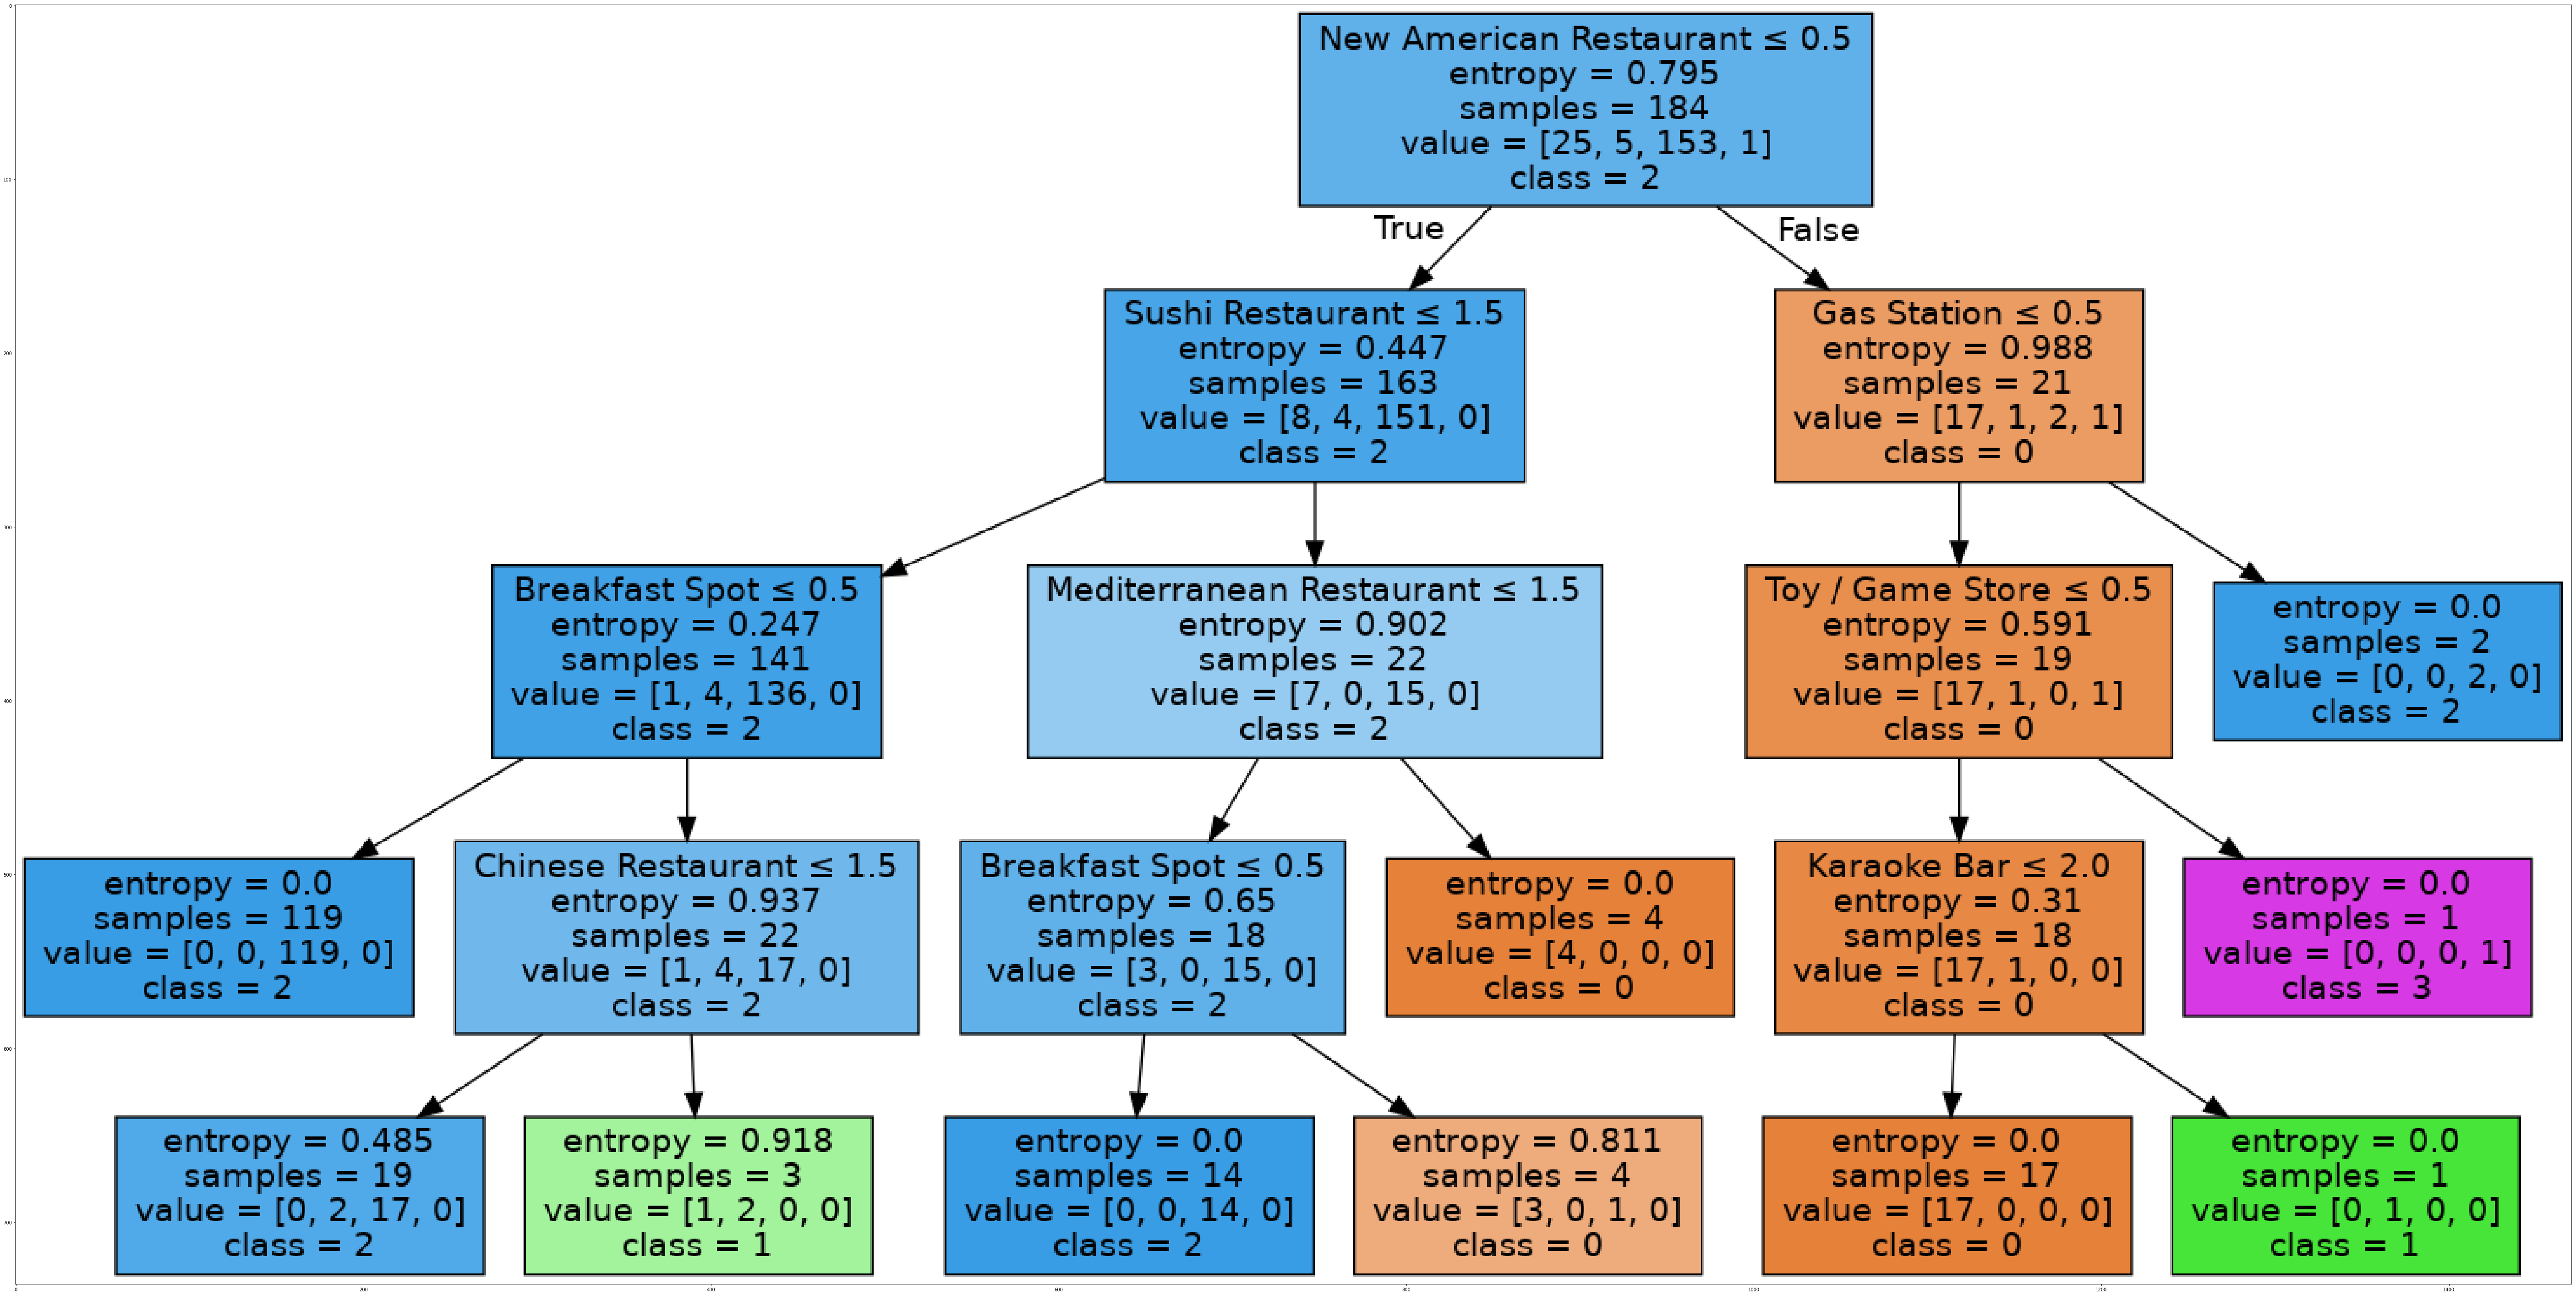

In [62]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 
y_display = [str(i) for i in y_trainset]
dot_data = StringIO()
filename = "hood.png"
featureNames = bob.columns[1:]
targetNames = bob["Cluster Labels"].unique().tolist()
out=tree.export_graphviz(hoodTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_display), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')